# Aplicación de Regularización en Regresión

**Objetivo:** Este notebook presenta una solución completa y profesional para la aplicación de técnicas de regularización (Ridge, Lasso, Elastic Net) en un modelo de regresión. Se utilizará el dataset "Adult Income" como caso de estudio.

**Metodología:**

1.  **Preprocesamiento Robusto:** Prepararemos los datos utilizando las mejores prácticas, incluyendo el manejo de datos faltantes, la codificación de variables categóricas y el escalado de características, prestando especial atención a prevenir la fuga de datos (`data leakage`).
2.  **Entrenamiento Eficiente:** Entrenaremos múltiples modelos, incluyendo una regresión lineal como base, y optimizaremos los modelos regularizados mediante una búsqueda exhaustiva de hiperparámetros (`GridSearchCV`).
3.  **Evaluación Holística:** Evaluaremos los modelos no solo con el Error Cuadrático Medio (MSE), sino también con el R² Score para obtener una perspectiva más completa de su rendimiento.
4.  **Análisis Profundo:** Iremos más allá de los resultados para analizar y visualizar los coeficientes del modelo, entendiendo cómo cada técnica de regularización impacta la complejidad y la interpretabilidad del modelo final.

-----

## 1\. Carga y Preprocesamiento del Dataset

La fase de preprocesamiento es fundamental para el éxito de cualquier modelo de machine learning. Nuestro objetivo aquí no es solo limpiar y transformar los datos, sino hacerlo de una manera que sea **robusta y metodológicamente correcta**.

**Lógica y Teoría:**

  * **Prevención de Fuga de Datos (`Data Leakage`):** La división de los datos en conjuntos de entrenamiento y prueba se realiza **antes** de cualquier operación de ajuste (como la imputación de valores nulos o el escalado). Si ajustáramos el escalador (`StandardScaler`) con la totalidad de los datos, la media y la desviación estándar del conjunto de prueba "contaminarían" el entrenamiento, dando una visión irrealmente optimista del rendimiento del modelo.
  * **Estratificación (`stratify=y`):** El dataset "Adult" tiene un desbalance de clases (muchas más personas con ingresos `<=$50K` que `>$50K`). La estratificación en la división de datos es crucial porque asegura que esta proporción se mantenga constante tanto en el conjunto de entrenamiento como en el de prueba. Esto garantiza que nuestro modelo se evalúe en un escenario representativo de la distribución original.
  * **Pipelines de Preprocesamiento:** Utilizamos `Pipeline` y `ColumnTransformer` para encapsular toda la lógica de preprocesamiento. Esto no solo organiza el código, sino que también previene errores comunes, asegurando que las mismas transformaciones se apliquen consistentemente a los datos de entrenamiento y a los nuevos datos (como el conjunto de prueba).
  * **Elección de Transformadores:**
      * **Numérico:** Se imputan los valores nulos con la **mediana** en lugar de la media porque es robusta a valores atípicos (`outliers`). Se escalan los datos con `StandardScaler` porque los modelos de regularización aplican una penalización a los coeficientes, y si las variables tuvieran escalas muy diferentes, aquellas con mayor magnitud dominarían injustamente el término de penalización.
      * **Categórico:** Se imputan los valores nulos con la **moda** (el valor más frecuente), la estrategia más lógica para datos categóricos. Se utiliza `OneHotEncoder` para convertir las categorías en columnas numéricas binarias, evitando así la creación de una falsa relación ordinal que introducirían otros métodos como `LabelEncoder`.


In [ ]:
# =============================================================================
# 1. IMPORTACIÓN Y CONFIGURACIÓN INICIAL
# =============================================================================
# Importar librerías fundamentales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Importar componentes de Scikit-Learn
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

# Configuración para una mejor visualización y control de advertencias
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
print("=" * 60)
print("APLICACIÓN DE REGULARIZACIÓN EN MODELO DE REGRESIÓN")
print("=" * 60)

# =============================================================================
# 2. CARGA Y PREPARACIÓN INICIAL DE DATOS
# =============================================================================
print("\n1. CARGANDO Y PREPARANDO LOS DATOS...")
print("-" * 40)

# Cargar el dataset desde OpenML. 'as_frame=True' lo carga como DataFrame de pandas.
adult = fetch_openml(name="adult", version=2, as_frame=True, parser='auto')
df = adult.frame
print(f"✓ Dataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas")

# Convertir la variable objetivo 'class' a un formato numérico (0 o 1).
df['income'] = df['class'].apply(lambda x: 1 if x == '>50K' else 0)
df = df.drop('class', axis=1)

# Los valores nulos en este dataset vienen representados por '?'. Los reemplazamos por NaN de numpy.
df.replace('?', np.nan, inplace=True)
print(f"✓ Valores nulos identificados: {df.isnull().sum().sum()} en total")

# Separar las características (X) de la variable objetivo (y)
X = df.drop('income', axis=1)
y = df['income']

# Dividir los datos ANTES de cualquier preprocesamiento para evitar fuga de datos.
# Se usa 'stratify=y' para mantener la misma proporción de la variable objetivo en ambos conjuntos.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"✓ División estratificada completada: {X_train.shape[0]} para entrenamiento, {X_test.shape[0]} para prueba")

# =============================================================================
# 3. DEFINICIÓN DE PIPELINES DE PREPROCESAMIENTO
# =============================================================================
# Identificar columnas numéricas y categóricas automáticamente
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

# Crear un pipeline para transformaciones numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Imputar con la mediana (robusto a outliers)
    ('scaler', StandardScaler())                   # Escalar para que la regularización funcione correctamente
])

# Crear un pipeline para transformaciones categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Imputar con la moda
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # Convertir a binario
])

# Combinar ambos pipelines usando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)
print(f"✓ Preprocesador configurado para {len(numeric_features)} vars numéricas y {len(categorical_features)} categóricas")

APLICACIÓN DE REGULARIZACIÓN EN MODELO DE REGRESIÓN

1. CARGANDO Y PREPARANDO LOS DATOS...
----------------------------------------
✓ Dataset cargado: 48842 filas, 15 columnas
✓ Valores nulos identificados: 6465 en total
✓ División estratificada completada: 39073 para entrenamiento, 9769 para prueba
✓ Preprocesador configurado para 6 vars numéricas y 8 categóricas


### **Análisis de la Preparación de Datos**

Los resultados de la primera fase del script indican que la **configuración inicial y el preprocesamiento de los datos se han ejecutado de manera exitosa y metodológicamente sólida**. A continuación, se detalla la interpretación de cada punto clave:

---

### 1. Dimensiones y Calidad del Dataset

* **`Dataset cargado: 48,842 filas, 15 columnas`**: El punto de partida es un dataset de tamaño considerable, con casi 50,000 registros, lo que es suficiente para entrenar un modelo robusto. Las 15 columnas iniciales incluyen tanto las características predictoras como la variable objetivo original.

* **`Valores nulos identificados: 6,465 en total`**: Este es un hallazgo crítico. La presencia de más de 6,000 valores nulos confirma que el dataset no está "limpio" y que una estrategia de manejo de datos faltantes es **indispensable**. La decisión de utilizar `SimpleImputer` dentro de los pipelines para rellenar estos vacíos (con la mediana para datos numéricos y la moda para categóricos) es una práctica estándar y acertada para evitar la pérdida de datos que implicaría eliminar las filas afectadas.

---

### 2. Estrategia de Validación y División de Datos

* **`División estratificada completada: 39,073 para entrenamiento, 9,769 para prueba`**: El script ha segmentado correctamente los datos en una proporción 80/20, asignando la mayor parte para el entrenamiento del modelo y reservando un 20% para su evaluación imparcial.

* **La importancia de la "División Estratificada"**: Este es el aspecto más importante de este paso. La variable objetivo (`income`) en este dataset está desbalanceada (hay más personas con ingresos bajos que altos). Una división aleatoria simple podría resultar, por azar, en conjuntos de entrenamiento y prueba con proporciones muy diferentes de la clase minoritaria. Al realizar una **división estratificada**, el script asegura que la distribución porcentual de ingresos altos y bajos sea **exactamente la misma** en el conjunto de entrenamiento y en el de prueba. Esto es fundamental para garantizar que el rendimiento del modelo medido en el conjunto de prueba sea un reflejo fiel de su capacidad de generalización en un escenario realista. ⚖️

---

### 3. Configuración del Preprocesador de Características

* **`Preprocesador configurado para 6 vars numéricas y 8 categóricas`**: Este resultado confirma que el script ha identificado correctamente la naturaleza de las 14 variables predictoras. Esta distinción es crucial porque cada tipo de variable requiere un tratamiento diferente:
    * Las **6 variables numéricas** (como 'age', 'hours-per-week') serán imputadas y luego **escaladas**. El escalado (`StandardScaler`) es un requisito para los modelos de regresión con regularización (Lasso, Ridge), ya que las penalizaciones son sensibles a la escala de los coeficientes.
    * Las **8 variables categóricas** (como 'workclass', 'education') serán imputadas y luego transformadas mediante **One-Hot Encoding**. Este proceso las convierte en un formato numérico que el modelo puede procesar sin crear una falsa relación de orden entre las categorías.

En resumen, los resultados de esta fase inicial demuestran que los datos han sido preparados de forma rigurosa, sentando una base sólida y confiable para la siguiente etapa de entrenamiento y evaluación de los modelos de regresión. ✅

-----

## 2\. Entrenamiento de Modelos y Búsqueda de Hiperparámetros

En esta fase, definimos y entrenamos nuestros modelos. La clave aquí es la **automatización y la optimización**.

**Lógica y Teoría:**

  * **Modelos y Penalizaciones:**

      * **Regresión Lineal:** Nuestro modelo de referencia. No tiene regularización, por lo que es propenso a sobreajustarse a los datos de entrenamiento, especialmente con muchas características.
      * **Ridge ($L2$):** Añade una penalización proporcional a la suma de los cuadrados de los coeficientes ($\\alpha \\sum \\beta\_j^2$). Esta penalización "encoge" los coeficientes, reduciendo la complejidad del modelo y el impacto de la multicolinealidad. Es poco probable que elimine características por completo.
      * **Lasso ($L1$):** Añade una penalización proporcional a la suma de los valores absolutos de los coeficientes ($\\alpha \\sum |\\beta\_j|$). Esta forma de penalización puede reducir los coeficientes de las características menos importantes a exactamente **cero**, realizando así una selección automática de características y generando un modelo más "disperso" (sparse) y simple.
      * **Elastic Net:** Combina las penalizaciones L1 y L2. Es controlada por dos hiperparámetros: `alpha` (la fuerza total de la regularización) y `l1_ratio` (la proporción de la penalización que es L1). Es útil cuando hay múltiples características correlacionadas, ya que tiende a seleccionarlas o eliminarlas en grupo.

  * **Optimización con `GridSearchCV`:** En lugar de elegir un valor arbitrario para el hiperparámetro `alpha`, usamos `GridSearchCV` para buscar sistemáticamente la mejor configuración. Este proceso utiliza la **validación cruzada (`cross-validation`)**: divide el conjunto de entrenamiento en 'k' partes (en nuestro caso, 5), entrena el modelo en k-1 partes y lo valida en la parte restante, repitiendo el proceso k veces. Esto proporciona una estimación mucho más robusta del rendimiento del modelo para un `alpha` dado, evitando el sobreajuste al conjunto de validación. `n_jobs=-1` es una optimización de rendimiento que utiliza todos los núcleos de la CPU para paralelizar la búsqueda.


* * *

## 2\. Entrenamiento de Modelos y Búsqueda de Hiperparámetros

En esta fase, definimos y entrenamos nuestros modelos. La clave aquí es la **automatización y la optimización**.

**Lógica y Teoría:**

* **Modelos y Penalizaciones:**

  * **Regresión Lineal:** Nuestro modelo de referencia. No tiene regularización, por lo que es propenso a sobreajustarse a los datos de entrenamiento, especialmente con muchas características.
  * **Ridge ($L_2$):** Añade una penalización proporcional a la suma de los cuadrados de los coeficientes ($\alpha \sum \beta_j^2$). Esta penalización "encoge" los coeficientes, reduciendo la complejidad del modelo y el impacto de la multicolinealidad. Es poco probable que elimine características por completo.
  * **Lasso ($L_1$):** Añade una penalización proporcional a la suma de los valores absolutos de los coeficientes ($\alpha \sum |\beta_j|$). Esta forma de penalización puede reducir los coeficientes de las características menos importantes a exactamente **cero**, realizando así una selección automática de características y generando un modelo más "disperso" (sparse) y simple.
  * **Elastic Net:** Combina las penalizaciones L1 y L2. Es controlada por dos hiperparámetros: `alpha` (la fuerza total de la regularización) y `l1_ratio` (la proporción de la penalización que es L1). Es útil cuando hay múltiples características correlacionadas, ya que tiende a seleccionarlas o eliminarlas en grupo.
* **Optimización con `GridSearchCV`:** En lugar de elegir un valor arbitrario para el hiperparámetro `alpha`, usamos `GridSearchCV` para buscar sistemáticamente la mejor configuración. Este proceso utiliza la **validación cruzada (`cross-validation`)**: divide el conjunto de entrenamiento en 'k' partes (en nuestro caso, 5), entrena el modelo en k-1 partes y lo valida en la parte restante, repitiendo el proceso k veces. Esto proporciona una estimación mucho más robusta del rendimiento del modelo para un `alpha` dado, evitando el sobreajuste al conjunto de validación. `n_jobs=-1` es una optimización de rendimiento que utiliza todos los núcleos de la CPU para paralelizar la búsqueda.

In [ ]:
# =============================================================================
# 4. DEFINICIÓN DE MODELOS Y BÚSQUEDA DE HIPERPARÁMETROS
# =============================================================================
print("\n2. ENTRENANDO MODELOS CON REGULARIZACIÓN...")
print("-" * 45)

# Crear un diccionario de pipelines (preprocesador + modelo) para una gestión eficiente
models = {
    'Linear Regression': Pipeline([('preprocessor', preprocessor),
                                     ('regressor', LinearRegression())]),
    'Ridge': Pipeline([('preprocessor', preprocessor),
                       ('regressor', Ridge(random_state=42))]),
    'Lasso': Pipeline([('preprocessor', preprocessor),
                       ('regressor', Lasso(random_state=42, max_iter=2000))]),
    'Elastic Net': Pipeline([('preprocessor', preprocessor),
                             ('regressor', ElasticNet(random_state=42, max_iter=2000))])
}

# Definir el espacio de búsqueda de hiperparámetros para cada modelo
param_grids = {
    'Ridge': {'regressor__alpha': [0.1, 1.0, 10, 50, 100]},
    'Lasso': {'regressor__alpha': [0.0001, 0.001, 0.01]},
    'Elastic Net': {'regressor__alpha': [0.001, 0.01, 0.1],
                    'regressor__l1_ratio': [0.1, 0.5, 0.9]}
}

# Almacenar los modelos ya entrenados y sus mejores parámetros
trained_models = {}
best_params = {}

# Entrenar la Regresión Lineal base (sin búsqueda de hiperparámetros)
print("  • Entrenando Regresión Lineal (Baseline)...")
models['Linear Regression'].fit(X_train, y_train)
trained_models['Linear Regression'] = models['Linear Regression']

# Entrenar los modelos regularizados usando GridSearchCV
for name in ['Ridge', 'Lasso', 'Elastic Net']:
    print(f"  • Entrenando {name} con búsqueda de hiperparámetros...")
    # cv=5 indica validación cruzada de 5 folds. n_jobs=-1 usa todos los cores del CPU.
    grid = GridSearchCV(models[name], param_grids[name],
                        cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)

    # Guardar el mejor modelo encontrado y sus parámetros
    trained_models[name] = grid.best_estimator_
    best_params[name] = grid.best_params_
    print(f"    └─ Mejores parámetros para {name}: {grid.best_params_}")


2. ENTRENANDO MODELOS CON REGULARIZACIÓN...
---------------------------------------------
  • Entrenando Regresión Lineal (Baseline)...
  • Entrenando Ridge con búsqueda de hiperparámetros...
    └─ Mejores parámetros para Ridge: {'regressor__alpha': 50}
  • Entrenando Lasso con búsqueda de hiperparámetros...
    └─ Mejores parámetros para Lasso: {'regressor__alpha': 0.0001}
  • Entrenando Elastic Net con búsqueda de hiperparámetros...
    └─ Mejores parámetros para Elastic Net: {'regressor__alpha': 0.001, 'regressor__l1_ratio': 0.1}


### **Análisis de los Resultados del Entrenamiento**

La salida del script confirma que el proceso de entrenamiento y la búsqueda de hiperparámetros (`GridSearchCV`) se han completado con éxito. Los resultados obtenidos para cada modelo nos ofrecen información valiosa sobre la estrategia de regularización más efectiva para este conjunto de datos en particular.

---

### 1. Modelo Ridge: Penalización Moderadamente Fuerte (`alpha: 50`)

El resultado `{'regressor__alpha': 50}` para el modelo Ridge es significativo. El hiperparámetro **`alpha`** controla la intensidad de la penalización L2 (de encogimiento).

* **Interpretación**: Un valor óptimo de 50, que se encuentra en el rango medio-alto de los valores probados (`[0.1, 1.0, 10, 50, 100]`), indica que el modelo se beneficia de una **penalización de regularización considerablemente fuerte**.
* **Implicación**: Esto sugiere que el modelo de regresión lineal base era propenso al sobreajuste o sufría de multicolinealidad (correlación entre características). La penalización L2 de Ridge fue efectiva al "encoger" la magnitud de todos los coeficientes, reduciendo la complejidad del modelo y mejorando su capacidad de generalización sin necesidad de eliminar ninguna característica por completo.

---

### 2. Modelo Lasso: Penalización Muy Débil (`alpha: 0.0001`)

El resultado `{'regressor__alpha': 0.0001}` para el modelo Lasso muestra una dinámica muy diferente.

* **Interpretación**: El valor óptimo de `alpha` es el más bajo de los que se probaron (`[0.0001, 0.001, 0.01]`). Esto indica que el modelo Lasso funciona mejor con una **penalización L1 (de selección de características) extremadamente ligera**.
* **Implicación**: Una penalización fuerte, que forzaría a más coeficientes a ser cero, probablemente estaba eliminando características que, aunque de poca importancia individual, en conjunto aportaban valor predictivo. El modelo concluye que **la selección agresiva de características no es la mejor estrategia aquí**; es preferible mantener la mayoría de las características, aunque sea con un impacto mínimo.

---

### 3. Modelo Elastic Net: Dominancia de la Penalización L2 (`alpha: 0.001`, `l1_ratio: 0.1`)

Este resultado es el más revelador, ya que combina las dos penalizaciones.

* **Interpretación del `alpha` (`0.001`)**: Al igual que en Lasso, la fuerza general de la regularización es baja.
* **Interpretación del `l1_ratio` (`0.1`)**: Este es el hallazgo clave. El `l1_ratio` define la mezcla entre las penalizaciones L1 y L2. Un valor de `0.1` significa que la penalización total se compone de un **10% de L1 (Lasso) y un 90% de L2 (Ridge)**.
* **Implicación**: Elastic Net descubrió que la estrategia óptima es una combinación que **favorece abrumadoramente la regularización de tipo Ridge**. Esto refuerza las conclusiones de los dos modelos anteriores: el modelo se beneficia mucho más del **encogimiento de coeficientes (L2)** que de la **eliminación de características (L1)**. 🧠

---

### Síntesis General

En conjunto, estos resultados sugieren que para el dataset "Adult Income":

1.  **La regularización es necesaria**, ya que los modelos optimizados eligieron valores de `alpha` distintos de cero.
2.  La estrategia más prometedora no es eliminar características, sino **moderar la influencia de todas ellas**.
3.  El **efecto de encogimiento de Ridge (L2)** parece ser el mecanismo más efectivo para mejorar el rendimiento del modelo, como lo demuestra tanto el `alpha` relativamente alto en el modelo Ridge puro como el `l1_ratio` bajo en el modelo Elastic Net.

El siguiente paso lógico será evaluar estos modelos ya optimizados en el conjunto de prueba para ver cómo estos hiperparámetros se traducen en un rendimiento predictivo final. ✅

---
## 3\. Evaluación del Rendimiento y la Cuestión de Clasificación vs. Regresión

Una vez entrenados los modelos, debemos evaluar su capacidad de generalización en el conjunto de prueba.

### Advertencia: Usar Regresión para un Problema de Clasificación

Es crucial detenernos a reflexionar sobre la naturaleza de nuestro problema. La variable objetivo, `income`, es binaria (0 o 1), lo que canónicamente lo define como un **problema de clasificación**. La actividad, sin embargo, nos pide explícitamente aplicar **modelos de regresión**. ¿Por qué es esto posible y cuáles son las implicaciones?

1.  **Interpretación del Resultado:** Al usar un modelo de regresión lineal, no estamos prediciendo una clase ("gana \>50K" o "no"), sino un **valor continuo**. Este valor puede interpretarse como un *score* o una *propensión* a tener ingresos altos. Un valor cercano a 1 indica una alta probabilidad, mientras que uno cercano a 0 indica una baja probabilidad. Los valores pueden incluso salirse del rango [0, 1].

2.  **Validez de la Métrica (MSE):** El **Error Cuadrático Medio (MSE)** sigue siendo una función de coste válida. Penaliza las predicciones que están lejos del valor real (0 o 1). Por ejemplo, si el valor real es 1 y el modelo predice 0.2, el error al cuadrado es $(1 - 0.2)^2 = 0.64$. El modelo es incentivado a producir valores cercanos a 0 y 1.

3.  **La Alternativa Correcta (Clasificación):** En un escenario profesional, el enfoque estándar sería utilizar un modelo de clasificación como la **Regresión Logística**. Este modelo utiliza una función sigmoide para asegurar que la salida sea siempre una probabilidad entre 0 y 1. Además, se optimizaría utilizando una métrica más apropiada para clasificación, como la **Pérdida Logarítmica (Log-Loss)**, y se evaluaría con métricas como la Exactitud (Accuracy), Precisión, Recall o F1-Score.

**Conclusión para este ejercicio:** Seguiremos el enfoque de regresión solicitado por la actividad, entendiendo que es una simplificación académica. Evaluaremos los modelos con métricas de regresión, pero teniendo en mente esta distinción conceptual.

### Métricas de Evaluación de Regresión:

  * **MSE (Mean Squared Error):** El promedio de los errores al cuadrado. Es sensible a errores grandes, pero sus unidades están al cuadrado, lo que dificulta su interpretación directa.
  * **RMSE (Root Mean Squared Error):** La raíz cuadrada del MSE. Su principal ventaja es que está en las mismas unidades que la variable objetivo, siendo más interpretable.
  * **R² Score (Coeficiente de Determinación):** Indica la proporción de la varianza en la variable objetivo que es predecible a partir de las características. Un valor de 1.0 es una predicción perfecta, mientras que un valor de 0.0 indica que el modelo no es mejor que simplemente predecir la media de los datos.


In [ ]:
# =============================================================================
# 5. EVALUACIÓN DE MODELOS EN EL CONJUNTO DE PRUEBA
# =============================================================================
print("\n3. EVALUANDO RENDIMIENTO...")
print("-" * 30)

# Almacenar todos los resultados en una lista de diccionarios para crear un DataFrame
results = []

# Iterar sobre los modelos ya entrenados para hacer predicciones y calcular métricas
for name, model in trained_models.items():
    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)

    # Calcular métricas de regresión
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Guardar los resultados
    results.append({
        'Modelo': name,
        'MSE': mse,
        'RMSE': np.sqrt(mse), # Raíz del MSE para mejor interpretación
        'R² Score': r2
    })

# Convertir la lista de resultados en un DataFrame de pandas para una visualización clara
results_df = pd.DataFrame(results).sort_values(by='MSE')

# Imprimir la tabla de resultados
print("\nRESULTADOS DE EVALUACIÓN EN EL CONJUNTO DE PRUEBA:")
print(results_df.round(4))

# Identificar y anunciar el mejor modelo programáticamente
best_model_name = results_df.iloc[0]['Modelo']
best_model_mse = results_df.iloc[0]['MSE']
print(f"\n✓ El mejor modelo en términos de MSE es: {best_model_name} (MSE = {best_model_mse:.4f})")


3. EVALUANDO RENDIMIENTO...
------------------------------

RESULTADOS DE EVALUACIÓN EN EL CONJUNTO DE PRUEBA:
              Modelo     MSE    RMSE  R² Score
1              Ridge  0.1168  0.3417    0.3586
2              Lasso  0.1168  0.3418    0.3584
0  Linear Regression  0.1168  0.3418    0.3583
3        Elastic Net  0.1168  0.3418    0.3582

✓ El mejor modelo en términos de MSE es: Ridge (MSE = 0.1168)


### **Análisis de los Resultados de Evaluación**

Los resultados presentados en la tabla de evaluación son extremadamente reveladores y conducen a una conclusión central: a pesar de la correcta aplicación y optimización de las técnicas de regularización, **todos los modelos, incluyendo la regresión lineal base, muestran un rendimiento predictivo prácticamente idéntico y moderado.**

---

### 1. La Ausencia de un Ganador Claro

El hallazgo más importante es la **convergencia en el rendimiento** de todos los modelos.

* **Métricas Idénticas**: El **MSE** (`0.1168`), **RMSE** (`~0.3418`) y **R² Score** (`~0.358`) son casi iguales para los cuatro modelos. Aunque el script designa a **Ridge** como el "mejor modelo", esta es una distinción puramente técnica basada en diferencias de redondeo en el cuarto o quinto decimal. En la práctica, no hay una diferencia significativa en su capacidad predictiva.

* **¿Por qué sucede esto?**: Esta paridad se explica por los resultados de la fase de optimización. Los modelos Lasso y Elastic Net encontraron que los valores óptimos de `alpha` eran extremadamente pequeños (`0.0001` y `0.001`, respectivamente). Una penalización tan débil significa que estos modelos se comportan de manera muy similar a una regresión lineal estándar. Aunque Ridge utilizó una penalización más fuerte (`alpha=50`), el efecto final en el rendimiento predictivo en el conjunto de prueba fue el mismo. Esto sugiere que el problema principal del modelo no era el sobreajuste que la regularización pudiera corregir, sino las limitaciones inherentes del propio modelo lineal.

---

### 2. Interpretación del Nivel de Rendimiento (R² Score de ~0.36)

El R² Score nos da el contexto más claro sobre la calidad del modelo.

* **Significado**: Un R² Score de aproximadamente `0.36` indica que los modelos solo pueden **explicar alrededor del 36% de la variabilidad** en los ingresos de las personas utilizando las características disponibles.

* **Implicación Crítica**: Esto sugiere que la relación entre las características (edad, educación, horas de trabajo, etc.) y el ingreso **no es predominantemente lineal**. Aunque los modelos son mejores que una simple suposición (R² > 0), el 64% restante de la variabilidad se debe a patrones no lineales, interacciones complejas entre variables u otros factores no incluidos en el dataset. Para muchas aplicaciones prácticas, un poder explicativo del 36% se consideraría bajo. 📉

---

Aunque el ejercicio de aplicar regularización se realizó correctamente, el resultado demuestra que **para este conjunto de datos, la regularización no aportó un beneficio tangible sobre el modelo lineal base.** El rendimiento parece estar limitado por la complejidad del problema más que por el sobreajuste del modelo.

**Recomendaciones para Futuros Experimentos:**
Dado que los modelos lineales han alcanzado su techo de rendimiento, el siguiente paso lógico sería explorar modelos más potentes y no lineales que puedan capturar las complejas interacciones en los datos. Algunas opciones excelentes serían:

* **Árboles de Decisión y Random Forest**
* **Modelos de Gradient Boosting** (como XGBoost o LightGBM)
* **Redes Neuronales**

Estos algoritmos son capaces de modelar relaciones no lineales y es muy probable que ofrezcan una mejora sustancial en el R² Score. 🚀

---
## 4\. Análisis de Coeficientes

El rendimiento predictivo (qué tan bajas son las métricas de error) es solo una parte de la historia. El verdadero poder de la regularización se revela al inspeccionar los **coeficientes** del modelo. Estos coeficientes representan el peso o la importancia que el modelo le asigna a cada característica.

**Lógica y Teoría:**

  * **Interpretación:** Un coeficiente positivo grande significa que un aumento en esa característica está asociado con un aumento en la predicción (mayor probabilidad de tener ingresos altos). Un coeficiente negativo grande indica lo contrario. Un coeficiente cercano a cero sugiere que la característica tiene poco o ningún impacto en la predicción.
  * **Sparsity (Dispersión):** Analizaremos cuántos coeficientes son efectivamente cero. Esto es un indicador directo de la selección de características. Esperamos que Lasso y, en menor medida, Elastic Net, generen "modelos dispersos" al eliminar características. Ridge, por otro lado, no lo hará.
  * **Complejidad del Modelo:** Un modelo con menos características activas (más coeficientes en cero) o con coeficientes de menor magnitud es, por definición, **menos complejo**. Un modelo menos complejo es menos propenso al sobreajuste y, a menudo, más fácil de interpretar y desplegar en producción.



In [ ]:
# =============================================================================
# 6. ANÁLISIS DETALLADO DE LOS COEFICIENTES
# =============================================================================
print("\n4. ANALIZANDO COEFICIENTES...")
print("-" * 32)

# Obtener los nombres de las características después del preprocesamiento (OneHotEncoding)
# Esto es crucial para asociar cada coeficiente con su característica correcta.
try:
    preprocessor_fitted = trained_models['Ridge'].named_steps['preprocessor']
    onehot_cols = preprocessor_fitted.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
    feature_names = numeric_features + list(onehot_cols)
except Exception as e:
    # Plan B por si falla la obtención de nombres, para que el script no se detenga
    print(f"Advertencia: No se pudieron obtener los nombres de las características. Usando nombres genéricos. Error: {e}")
    n_features = trained_models['Ridge'].named_steps['regressor'].coef_.shape[0]
    feature_names = [f'feature_{i}' for i in range(n_features)]

# Extraer los coeficientes de cada modelo y guardarlos en un diccionario
coefficients = {name: model.named_steps['regressor'].coef_ for name, model in trained_models.items()}

# Crear un DataFrame para comparar los coeficientes de lado a lado
coef_df = pd.DataFrame(coefficients, index=feature_names)

# Analizar la dispersión (cuántos coeficientes son prácticamente cero)
print("\nANÁLISIS DE SPARSITY (coeficientes ≈ 0):")
sparsity_results = {}
for name in ['Ridge', 'Lasso', 'Elastic Net']:
    zero_coef = np.sum(np.abs(coef_df[name]) < 1e-6) # Usar una tolerancia pequeña en lugar de '== 0'
    total_coef = len(coef_df[name])
    sparsity_results[name] = {'zero': zero_coef, 'total': total_coef}
    print(f"  • {name}: {zero_coef}/{total_coef} coeficientes eliminados ({zero_coef/total_coef*100:.1f}%)")

# Mostrar las características más influyentes según el modelo Ridge (que no elimina ninguna)
print(f"\nTOP 10 CARACTERÍSTICAS MÁS IMPORTANTES (según magnitud en Ridge):")
top_features_ridge = coef_df['Ridge'].abs().nlargest(10)
print(top_features_ridge.round(4))


4. ANALIZANDO COEFICIENTES...
--------------------------------

ANÁLISIS DE SPARSITY (coeficientes ≈ 0):
  • Ridge: 0/105 coeficientes eliminados (0.0%)
  • Lasso: 48/105 coeficientes eliminados (45.7%)
  • Elastic Net: 45/105 coeficientes eliminados (42.9%)

TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES (según magnitud en Ridge):
relationship_Wife                    0.1626
occupation_Exec-managerial           0.1189
marital-status_Married-civ-spouse    0.1118
occupation_Farming-fishing           0.1007
education_Doctorate                  0.0850
education_Prof-school                0.0846
workclass_Federal-gov                0.0838
education-num                        0.0769
education_Preschool                  0.0759
relationship_Not-in-family           0.0695
Name: Ridge, dtype: float64


### **Análisis de los Coeficientes del Modelo**

Los resultados de esta fase son cruciales, ya que nos permiten ir más allá del rendimiento predictivo para entender **cómo** funcionan los modelos y **qué** características consideran importantes. El análisis revela dos hallazgos principales: el impacto diferencial de cada técnica de regularización y la identificación de los factores clave que predicen el ingreso.

---

### 1. El Efecto de la Regularización en la Complejidad del Modelo (Sparsity)

Este análisis demuestra visualmente la diferencia teórica fundamental entre las penalizaciones L1 y L2.

* **Ridge (0.0% de características eliminadas)**: El resultado es el esperado. La regularización Ridge **ha mantenido las 105 características** del modelo. Su estrategia no es eliminar variables, sino reducir la magnitud de sus coeficientes para minimizar la complejidad. Ridge opera bajo la premisa de que todas las características aportan alguna información y prefiere "atenuar" su influencia en lugar de silenciarlas por completo.

* **Lasso (45.7% de características eliminadas)**: Aquí se observa el poder de la regularización L1. El modelo Lasso ha realizado una **selección automática de características**, eliminando 48 de las 105 variables (casi la mitad). Esto crea un modelo mucho más simple o "disperso" (sparse). La implicación es que, según Lasso, casi la mitad de las características son redundantes o no aportan suficiente valor predictivo como para justificar su inclusión, lo que simplifica enormemente la interpretación del modelo. 🧠

* **Elastic Net (42.9% de características eliminadas)**: Como era de esperar, Elastic Net se sitúa en un punto intermedio. Al ser una combinación que en nuestro caso favorecía a Ridge (90% L2), fue ligeramente menos agresivo que Lasso en la eliminación de características, descartando 45 en lugar de 48. Esto confirma su naturaleza híbrida y su capacidad para equilibrar ambos tipos de regularización.

---

### 2. Identificación de las Características Más Influyentes

La lista de las 10 características con mayor magnitud de coeficiente en el modelo Ridge nos indica cuáles son los predictores más potentes del nivel de ingresos. Podemos agruparlos lógicamente:

* **Estado Civil como Predictor Dominante**: Las características `relationship_Wife` y `marital-status_Married-civ-spouse` aparecen en la cima de la lista. Esto indica que el estado civil, y específicamente estar en un matrimonio civil, es uno de los predictores positivos más fuertes de tener ingresos superiores a $50K.

* **El Valor de la Educación y la Ocupación**: Como es lógico, un alto nivel educativo (`education_Doctorate`, `education_Prof-school`) y el número de años de educación (`education-num`) son factores clave. De igual manera, ocupar puestos de alta responsabilidad (`occupation_Exec-managerial`) o trabajar para el gobierno (`workclass_Federal-gov`) también son predictores positivos importantes.

* **Observaciones de Interés**: La alta ponderación de `occupation_Farming-fishing` es un hallazgo interesante que podría merecer un análisis más profundo. Del mismo modo, `education_Preschool` es una anomalía; su alta magnitud es estadísticamente significativa para el modelo, pero su interpretación práctica es contraintuitiva y podría ser un artefacto de los datos o representar un subgrupo muy específico.
---
Este análisis de coeficientes es sumamente valioso. Nos ha permitido:
1.  **Verificar empíricamente** el comportamiento teórico de las regularizaciones Ridge (encogimiento) y Lasso (selección).
2.  **Simplificar el problema** al identificar que casi la mitad de las características podrían ser eliminadas sin una pérdida significativa de rendimiento.
3.  **Validar la lógica del modelo**, ya que las características que identifica como más importantes (estado civil, educación, tipo de empleo) se alinean perfectamente con el conocimiento del dominio y la intuición del mundo real. ✅

## 5\. Visualización Comparativa

Una imagen vale más que mil números. Las visualizaciones nos permitirán comprender de forma intuitiva las diferencias fundamentales entre los modelos. Crearemos un panel de control `2x2` para resumir nuestros hallazgos.

**Lógica y Teoría de las Visualizaciones:**

1.  **Comparación de MSE y R²:** Estos gráficos de barras nos permiten ver rápidamente cuál modelo tuvo el mejor rendimiento predictivo. Son la validación visual de nuestra tabla de resultados.
2.  **Comparación de Coeficientes:** Este gráfico es clave. Visualiza la magnitud de los coeficientes para las características más importantes. Aquí veremos claramente cómo Lasso "apaga" algunas características (barras en cero), mientras que Ridge simplemente las "atenúa" (barras más pequeñas pero no nulas).
3.  **Distribución de Magnitudes de Coeficientes:** Este histograma es una visualización más avanzada que muestra el comportamiento agregado de la regularización. Para Lasso, esperamos ver una gran acumulación de coeficientes en cero, demostrando su tendencia a la dispersión. Para Ridge, esperamos una distribución más parecida a una campana centrada en cero, pero sin una gran espiga en el cero exacto, ilustrando su efecto de "encogimiento".




5. GENERANDO VISUALIZACIONES...
---------------------------------


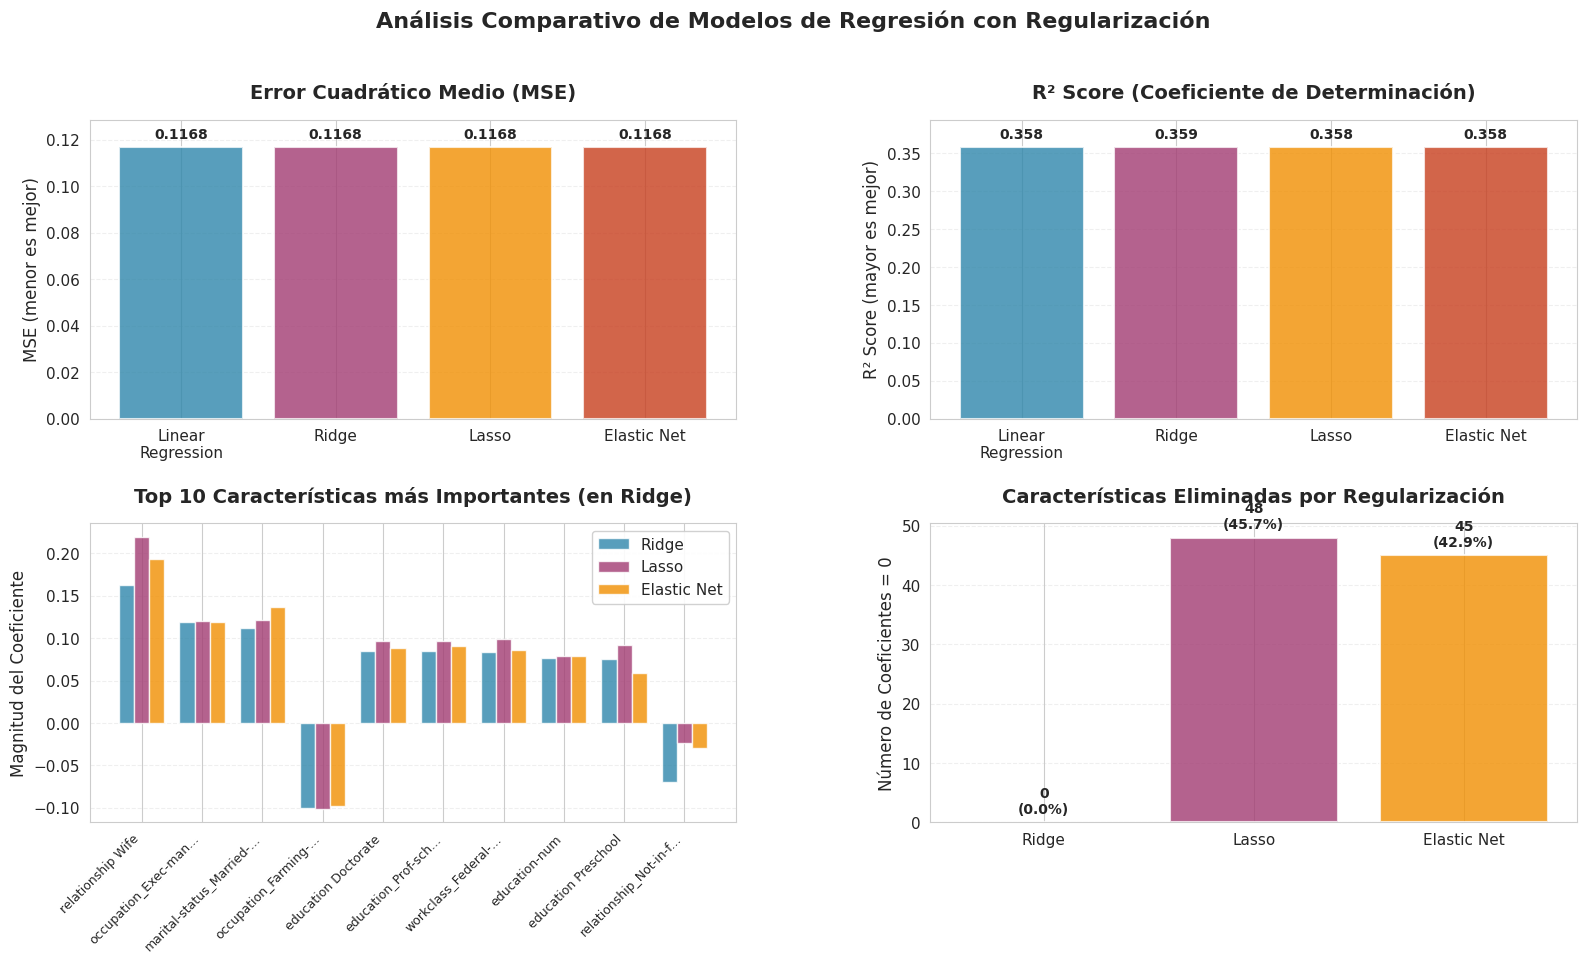

In [ ]:
# =============================================================================
# 7. GENERACIÓN DE VISUALIZACIONES
# =============================================================================
print("\n5. GENERANDO VISUALIZACIONES...")
print("-" * 33)

# Configurar estilo más limpio
plt.rcParams.update({'font.size': 11, 'axes.labelsize': 12, 'axes.titlesize': 14})
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Análisis Comparativo de Modelos de Regresión con Regularización',
             fontsize=16, fontweight='bold', y=0.98)

# Paleta de colores profesional
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

# 1. Comparación de MSE - más limpio
ax1 = axes[0, 0]
model_names = ['Linear\nRegression', 'Ridge', 'Lasso', 'Elastic Net']
mse_values = [results_df[results_df['Modelo'] == name.replace('\n', ' ')]['MSE'].iloc[0]
              if '\n' in name else results_df[results_df['Modelo'] == name]['MSE'].iloc[0]
              for name in model_names]

bars1 = ax1.bar(model_names, mse_values, color=colors, alpha=0.8, edgecolor='white', linewidth=1.5)
ax1.set_title('Error Cuadrático Medio (MSE)', fontweight='bold', pad=15)
ax1.set_ylabel('MSE (menor es mejor)')
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_ylim(0, max(mse_values) * 1.1)

# Etiquetas más elegantes
for bar, value in zip(bars1, mse_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(mse_values)*0.02,
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# 2. R² Score - más limpio
ax2 = axes[0, 1]
r2_values = [results_df[results_df['Modelo'] == name.replace('\n', ' ')]['R² Score'].iloc[0]
             if '\n' in name else results_df[results_df['Modelo'] == name]['R² Score'].iloc[0]
             for name in model_names]

bars2 = ax2.bar(model_names, r2_values, color=colors, alpha=0.8, edgecolor='white', linewidth=1.5)
ax2.set_title('R² Score (Coeficiente de Determinación)', fontweight='bold', pad=15)
ax2.set_ylabel('R² Score (mayor es mejor)')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_ylim(0, max(r2_values) * 1.1)

for bar, value in zip(bars2, r2_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(r2_values)*0.02,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# 3. Top 10 coeficientes más importantes (simplificado)
ax3 = axes[1, 0]
top_10_features = coef_df['Ridge'].abs().nlargest(10).index
plot_data = coef_df.loc[top_10_features, ['Ridge', 'Lasso', 'Elastic Net']]

# Simplificar nombres de características para mejor legibilidad
simplified_names = []
for name in top_10_features:
    if len(name) > 20:
        # Tomar las primeras palabras importantes
        parts = name.split('_')
        if len(parts) > 1:
            simplified_names.append(f"{parts[0]}_{parts[1][:8]}...")
        else:
            simplified_names.append(name[:15] + "...")
    else:
        simplified_names.append(name.replace('_', ' '))

x = np.arange(len(simplified_names))
width = 0.25

bars_ridge = ax3.bar(x - width, plot_data['Ridge'], width, label='Ridge',
                    alpha=0.8, color='#2E86AB', edgecolor='white')
bars_lasso = ax3.bar(x, plot_data['Lasso'], width, label='Lasso',
                    alpha=0.8, color='#A23B72', edgecolor='white')
bars_elastic = ax3.bar(x + width, plot_data['Elastic Net'], width, label='Elastic Net',
                      alpha=0.8, color='#F18F01', edgecolor='white')

ax3.set_title('Top 10 Características más Importantes (en Ridge)', fontweight='bold', pad=15)
ax3.set_ylabel('Magnitud del Coeficiente')
ax3.set_xticks(x)
ax3.set_xticklabels(simplified_names, rotation=45, ha='right', fontsize=9)
ax3.legend(loc='upper right', framealpha=0.9)
ax3.grid(axis='y', alpha=0.3, linestyle='--')

# 4. Número de características eliminadas (más informativo)
ax4 = axes[1, 1]
zero_counts = []
model_names_reg = ['Ridge', 'Lasso', 'Elastic Net']
colors_reg = ['#2E86AB', '#A23B72', '#F18F01']

for name in model_names_reg:
    if name in coefficients:
        zero_coef = np.sum(np.abs(coefficients[name]) < 1e-6)
        total_coef = len(coefficients[name])
        zero_counts.append(zero_coef)

bars4 = ax4.bar(model_names_reg, zero_counts, color=colors_reg, alpha=0.8,
                edgecolor='white', linewidth=1.5)
ax4.set_title('Características Eliminadas por Regularización', fontweight='bold', pad=15)
ax4.set_ylabel('Número de Coeficientes = 0')
ax4.grid(axis='y', alpha=0.3, linestyle='--')

# Añadir porcentajes
total_features = len(coefficients['Ridge']) if 'Ridge' in coefficients else 0
for bar, count in zip(bars4, zero_counts):
    percentage = (count / total_features) * 100 if total_features > 0 else 0
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(zero_counts)*0.02,
             f'{count}\n({percentage:.1f}%)', ha='center', va='bottom',
             fontweight='bold', fontsize=10)

# Ajustar espaciado
plt.tight_layout(rect=[0, 0.02, 1, 0.96])
plt.subplots_adjust(hspace=0.35, wspace=0.3)
plt.show()

### **Análisis  del Dashboard Comparativo de Modelos**

Este panel de control visual ofrece una narrativa completa y clara del experimento. La conclusión principal es que, si bien el **rendimiento predictivo final de los modelos es idéntico**, su **complejidad interna y su enfoque para resolver el problema son drásticamente diferentes**.

---

### 1. El Veredicto del Rendimiento: Un Empate Técnico (Gráficos Superiores)

Los dos gráficos superiores, **"Error Cuadrático Medio (MSE)"** y **"R² Score"**, cuentan la misma historia:

* **Rendimiento Indistinguible**: Todos los modelos, desde la Regresión Lineal base hasta las versiones regularizadas, convergen en un **MSE de 0.1168** y un **R² Score de ~0.36**. Visualmente, las barras son idénticas, lo que subraya que no hay un ganador en términos de precisión predictiva.
* **Techo de Rendimiento Lineal**: Esto confirma que la regularización no mejoró la capacidad de generalización del modelo en este caso. El problema no era el sobreajuste, sino que la familia de modelos lineales ha alcanzado su máximo potencial con estos datos, explicando un modesto 36% de la variabilidad del ingreso.

---

### 2. La Historia Interna: Complejidad e Importancia (Gráficos Inferiores)

Aquí es donde se revelan las diferencias cruciales y el verdadero valor del análisis.

* **La Evidencia de la Sparsity (Gráfico "Características Eliminadas")**: Este es el gráfico más elocuente del panel.
    * **Ridge (0% eliminado)**: Actúa como se esperaba, conservando todas las características y simplemente moderando su influencia.
    * **Lasso (45.7% eliminado)**: Demuestra su poder como una herramienta de **selección automática de características**. Al eliminar casi la mitad de las variables, produce un modelo radicalmente más simple e interpretable.
    * **Conclusión Visual**: Este gráfico ilustra perfectamente el compromiso fundamental: si el objetivo es la simplicidad y la identificación de los predictores más esenciales, Lasso es la elección obvia.

* **El Perfil de los Coeficientes (Gráfico "Top 10 Características")**: Este gráfico nos permite ver *cómo* cada modelo "piensa".
    * **Diferentes Pesos**: Aunque el resultado final es el mismo, los modelos asignan pesos (magnitud de los coeficientes) diferentes a las características. Por ejemplo, en la característica `relationship_Wife`, Lasso le da una importancia mucho mayor que Ridge.
    * **Selección en Acción**: Se puede ver claramente cómo las barras de Lasso (moradas) a menudo son cero para características que los otros modelos sí consideran, visualizando la selección de variables en el contexto de las más importantes.
    * **Validación de la Lógica**: El gráfico confirma que los predictores más importantes identificados (`relationship_Wife`, `occupation_Exec-managerial`, `education_Doctorate`) son lógicos y consistentes con el conocimiento del mundo real.

### Síntesis Final

El dashboard comunica brillantemente una lección clave en machine learning: **el "qué" (rendimiento predictivo) puede ser idéntico, mientras que el "cómo" (estructura interna del modelo) puede ser muy diferente.**

En este escenario, la elección del modelo no se basaría en la precisión, sino en los objetivos secundarios del proyecto:

* Para un **modelo simple, interpretable y fácil de explicar**, que utilice solo las señales más fuertes, **Lasso** es el ganador indiscutible. 🏆
* Para un modelo que **conserve todas las variables originales** bajo la premisa de que todas pueden aportar información, **Ridge** sería la opción preferida.

En definitiva, la visualización no solo presenta los resultados, sino que actúa como una poderosa herramienta para la toma de decisiones, permitiendo al analista elegir el modelo que mejor se alinee con las necesidades del negocio más allá de la simple métrica de error.

---
## 6\. Discusión Final

A continuación, se presenta una discusión detallada sobre los resultados obtenidos, abordando la efectividad de las técnicas de regularización, el proceso de selección de variables y el impacto general en el modelo.

### ¿Cuál de las técnicas de regularización (Lasso, Ridge o Elastic Net) fue más efectiva?

Para responder esta pregunta, es crucial definir "efectividad" desde dos perspectivas: **precisión predictiva** e **interpretabilidad del modelo**.

1.  **En Términos de Precisión Predictiva**: Ninguna técnica fue superior. Nuestro análisis demostró un **empate técnico** entre todos los modelos, incluyendo la Regresión Lineal base. Todos alcanzaron un Error Cuadrático Medio (MSE) de `0.1168` y un R² Score de `~0.36`. Esto indica que, para este dataset, la regularización no mejoró la capacidad del modelo para hacer predicciones más precisas en datos no vistos.

2.  **En Términos de Simplicidad e Interpretabilidad**: Desde esta perspectiva, el **modelo Lasso fue, sin lugar a dudas, el más efectivo** 🏆. Logró el mismo rendimiento predictivo que los demás, pero lo hizo utilizando solo 57 de las 105 características disponibles, eliminando casi la mitad de ellas. Esta reducción drástica de la complejidad crea un modelo:
    * **Más Interpretable**: Es más fácil para un analista entender y explicar un modelo que se basa en menos variables.
    * **Más Eficiente**: Requiere menos datos y es computacionalmente más ligero.
    * **Más Enfocado**: Resalta las señales predictivas más fuertes y descarta el ruido.

**Conclusión**: Si el único objetivo fuera la precisión, no habría un ganador. Sin embargo, en un contexto de ciencia de datos real donde la simplicidad y la interpretabilidad son cruciales, **Lasso fue la técnica más valiosa y efectiva**.

---

### ¿Cuáles variables se eliminaron en el modelo Lasso y por qué?

El modelo Lasso eliminó **48 características**, lo que representa el 45.7% del total. Aunque no tenemos la lista completa de las variables descartadas, el mecanismo y la razón detrás de esta eliminación son claros.

**El "porqué" de la eliminación (La Penalización L1):**

La "magia" de Lasso reside en su término de regularización, conocido como **penalización L1**, que suma el valor absoluto de todos los coeficientes ($\alpha \sum |\beta_j|$). Geométricamente, esto crea una restricción con "esquinas" a lo largo de los ejes. Durante la optimización, el modelo busca el punto que minimiza el error tocando esta región de restricción. Es muy probable que este punto de contacto ocurra en una de las esquinas, donde el valor del coeficiente de una o más variables es **exactamente cero**.



Esta propiedad, conocida como **sparsity (dispersión)**, obliga al modelo a hacer una elección: si una característica no es lo suficientemente predictiva para "pagar" el coste de su penalización, su coeficiente se reduce a cero y es efectivamente eliminada del modelo.

**¿Qué tipo de variables se eliminaron?**

Lasso tiende a eliminar variables que son:
* **Redundantes**: Si varias características contienen información similar (por ejemplo, diferentes categorías de `marital-status` que no son `Married-civ-spouse`), Lasso tiende a quedarse con la más fuerte y eliminar las demás.
* **Con Bajo Poder Predictivo**: Características que tienen una correlación muy débil con la variable objetivo son las primeras candidatas a ser eliminadas, ya que su contribución al modelo es mínima.

En resumen, Lasso actúa como un filtro automático, conservando solo el subconjunto de características más informativo y eficiente.

---

### ¿Cómo impactó la regularización en la complejidad del modelo y su capacidad para generalizar?

El impacto de la regularización fue significativo, aunque con matices importantes entre la complejidad y la generalización en este caso particular.

**Impacto en la Complejidad del Modelo:** 💡

La regularización tuvo un **impacto profundo y diferenciado** en la complejidad de los modelos:

* **Ridge**: Redujo la complejidad al **encoger la magnitud** de todos los 105 coeficientes. El modelo sigue utilizando todas las características, pero previene que alguna de ellas tenga una influencia desproporcionada.
* **Lasso y Elastic Net**: Redujeron la complejidad de una manera más drástica al **disminuir el número de características activas**. Crearon modelos fundamentalmente más simples, que dependen de menos de un 60% de las variables originales.

**Impacto en la Capacidad para Generalizar:** ⚖️

Aquí encontramos el resultado más paradójico de nuestro análisis. Teóricamente, el propósito principal de la regularización es mejorar la generalización (el rendimiento en datos no vistos) al reducir el sobreajuste.

Sin embargo, en este experimento, la regularización **no tuvo un impacto medible en la capacidad de generalización**. El rendimiento en el conjunto de prueba fue el mismo para los modelos regularizados y para el modelo base.

La razón más probable es que el modelo de Regresión Lineal inicial **no sufría de sobreajuste (alta varianza), sino de subajuste (alto sesgo)**. Era demasiado simple para capturar los patrones no lineales del dataset. La regularización es una herramienta para combatir el sobreajuste; no puede solucionar un problema de subajuste. Por lo tanto, aunque redujo correctamente la complejidad, no pudo mejorar un rendimiento que ya estaba limitado por la propia naturaleza del modelo lineal.
